In [2]:
import os
import glob
import boto3
import pprint
from tqdm import tqdm
import sagemaker
from sagemaker.collection import Collection

In [3]:
sagemaker_session =  sagemaker.session.Session(boto3.session.Session(region_name="us-east-1")) #sagemaker.session.Session()
region = sagemaker_session.boto_region_name
role = sagemaker.get_execution_role()
default_bucket = sagemaker_session.default_bucket()
sm_client = boto3.client('sagemaker', region_name=region)
model_collector = Collection(sagemaker_session=sagemaker_session)

## Define Parameters 

In [20]:
# define base model name
model_id = "Mikael110/llama-2-13b-guanaco-fp16" 
# define a base dataset to finetune this base model
dataset_name = "databricks/databricks-dolly-15k"
# base model collection name
model_registry_name_base = f"{model_id.replace('/', '-')}-base"
model_group_for_base = "llama-2-13b" # we'll group all llama-2 variants under this collection 
# finetuned model collection name
model_registry_name_finetuned = f"{model_id.replace('/', '-')}-finetuned"
model_group_for_finetune = dataset_name.split('/')[-1] # we will group all dataset finetunes to this and attach it back to the parent model

## Prepare Dataset

In [21]:
from datasets import load_dataset
from random import randrange

# Load dataset from the hub
train_dataset = load_dataset(dataset_name, split="train[:05%]")
validation_dataset = load_dataset(dataset_name, split="train[95%:]")

print(f"Training size: {len(train_dataset)} | Validation size: {len(validation_dataset)}")
print("\nTraining sample:\n")
print(train_dataset[randrange(len(train_dataset))])
print("\nValidation sample:\n")
print(validation_dataset[randrange(len(validation_dataset))])

Training size: 751 | Validation size: 751

Training sample:

{'instruction': 'In the series A Song of Ice and Fire, who is the founder of House Karstark?', 'context': '', 'response': 'Karlon Stark', 'category': 'open_qa'}

Validation sample:

{'instruction': 'What is the fastest point of sail?', 'context': '', 'response': 'The fastest point of sail on a traditional sailing vessel is the beam reach.', 'category': 'general_qa'}


In [22]:
def format_dolly(sample):
    instruction = f"### Instruction\n{sample['instruction']}"
    context = f"### Context\n{sample['context']}" if len(sample["context"]) > 0 else None
    response = f"### Answer\n{sample['response']}"
    # join all the parts together
    prompt = "\n\n".join([i for i in [instruction, context, response] if i is not None])
    return prompt

In [23]:
from random import randrange

print(format_dolly(train_dataset[randrange(len(train_dataset))]))

### Instruction
Give me the top 5 golf equipment company names.

### Answer
Titleist, Taylormade, Callaway, Ping, Cobra


In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

In [9]:
from random import randint
from itertools import chain
from functools import partial


# template dataset to add prompt to each sample
def template_dataset(sample):
    sample["text"] = f"{format_dolly(sample)}{tokenizer.eos_token}"
    return sample


# apply prompt template per sample
# train
train_dataset = train_dataset.map(template_dataset, remove_columns=list(train_dataset.features))
# validation
validation_dataset = validation_dataset.map(template_dataset, remove_columns=list(validation_dataset.features))
# print random sample
print(validation_dataset[randint(0, len(validation_dataset))]["text"])

# empty list to save remainder from batches to use in next batch
remainder = {"input_ids": [], "attention_mask": [], "token_type_ids": []}

def chunk(sample, chunk_length=2048):
    # define global remainder variable to save remainder from batches to use in next batch
    global remainder
    # Concatenate all texts and add remainder from previous batch
    concatenated_examples = {k: list(chain(*sample[k])) for k in sample.keys()}
    concatenated_examples = {k: remainder[k] + concatenated_examples[k] for k in concatenated_examples.keys()}
    # get total number of tokens for batch
    batch_total_length = len(concatenated_examples[list(sample.keys())[0]])

    # get max number of chunks for batch
    if batch_total_length >= chunk_length:
        batch_chunk_length = (batch_total_length // chunk_length) * chunk_length

    # Split by chunks of max_len.
    result = {
        k: [t[i : i + chunk_length] for i in range(0, batch_chunk_length, chunk_length)]
        for k, t in concatenated_examples.items()
    }
    # add remainder to global variable for next batch
    remainder = {k: concatenated_examples[k][batch_chunk_length:] for k in concatenated_examples.keys()}
    # prepare labels
    result["labels"] = result["input_ids"].copy()
    return result


# tokenize and chunk dataset

# training
lm_train_dataset = train_dataset.map(
    lambda sample: tokenizer(sample["text"]), batched=True, remove_columns=list(train_dataset.features)
).map(
    partial(chunk, chunk_length=2048),
    batched=True,
)

# validation
lm_valid_dataset = validation_dataset.map(
    lambda sample: tokenizer(sample["text"]), batched=True, remove_columns=list(validation_dataset.features)
).map(
    partial(chunk, chunk_length=2048),
    batched=True,
)

# Print total number of samples
print(f"Total number of samples: {len(validation_dataset)}")

Map:   0%|          | 0/751 [00:00<?, ? examples/s]

Map:   0%|          | 0/751 [00:00<?, ? examples/s]

### Instruction
Why is pricing important in the overall strategy of a product?

### Answer
When different profit levers like price, variable cost, fixed cost, volume of goods sold are compared, studies show that a 1% improvement in price can create the maximum operating profit improvement of 11.5% compared to only 2.3% through fixed costs. This goes to show that pricing can have a monumental impact on the bottom line. 

This can be achieved by understanding different pricing strategies and how they can be executed through pricing tactics. The different pricing strategy includes using - 1. Cost-side factors (like fixed, variable costs, incremental break-even analysis); 2. Customer-side factors (like Economic Value Analysis (EVA); Price Elasticity of Demand; Measuring willingness to pay) 3. Competitive environment factors. 

Based on the business context, these strategies can be implemented with tacts like price discrimination (e.g., bundling); non-linear pricing; price promotions (e.g.,

Map:   0%|          | 0/751 [00:00<?, ? examples/s]

Map:   0%|          | 0/751 [00:00<?, ? examples/s]

Map:   0%|          | 0/751 [00:00<?, ? examples/s]

Map:   0%|          | 0/751 [00:00<?, ? examples/s]

Total number of samples: 751


In [10]:
# save train_dataset to s3
training_input_path = f's3://{default_bucket}/largelanguagemodels/{model_id}/dataset/train'
lm_train_dataset.save_to_disk(training_input_path)

print(f"saving training dataset to: {training_input_path}")

Saving the dataset (0/1 shards):   0%|          | 0/78 [00:00<?, ? examples/s]

saving training dataset to: s3://sagemaker-us-east-1-811828458885/largelanguagemodels/Mikael110/llama-2-13b-guanaco-fp16/dataset/train


In [11]:
# save train_dataset to s3
validation_input_path = f's3://{default_bucket}/largelanguagemodels/{model_id}/dataset/validation'
lm_valid_dataset.save_to_disk(validation_input_path)

print(f"saving validation dataset to: {validation_input_path}")

Saving the dataset (0/1 shards):   0%|          | 0/71 [00:00<?, ? examples/s]

saving validation dataset to: s3://sagemaker-us-east-1-811828458885/largelanguagemodels/Mikael110/llama-2-13b-guanaco-fp16/dataset/validation


## Save Base model into Model Registry

In [12]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

In [13]:
base_model_save_dir = f"./base_model/{model_id}"
os.makedirs(base_model_save_dir, exist_ok=True)

In [14]:
tokenizer = AutoTokenizer.from_pretrained(model_id).save_pretrained(base_model_save_dir)
model = AutoModelForCausalLM.from_pretrained(
    model_id, 
    torch_dtype=torch.float16, 
    device_map="auto"
).save_pretrained(base_model_save_dir) 

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [15]:
del model
import torch; torch.cuda.empty_cache()

In [16]:
model_tar_filename = f"{model_id.replace('/', '-')}.tar.gz"
print(f"Model tar file name: {model_tar_filename}")

Model tar file name: Mikael110-llama-2-13b-guanaco-fp16.tar.gz


In [17]:
!cd ./base_model && tar -cvf ./{model_tar_filename} ./{model_id}

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
./Mikael110/llama-2-13b-guanaco-fp16/
./Mikael110/llama-2-13b-guanaco-fp16/pytorch_model-00001-of-00003.bin
./Mikael110/llama-2-13b-guanaco-fp16/tokenizer_config.json
./Mikael110/llama-2-13b-guanaco-fp16/pytorch_model-00003-of-00003.bin
./Mikael110/llama-2-13b-guanaco-fp16/tokenizer.model
./Mikael110/llama-2-13b-guanaco-fp16/config.json
./Mikael110/llama-2-13b-guanaco-fp16/pytorch_model.bin.index.json
./Mikael110/llama-2-13b-guanaco-fp16/pytorch_model-00002-of-00003.bin
./Mikael110/llama-2-13b-guanaco-fp16/generation_config.json
./Mikael110/llama-2-13b-guanaco-fp16/special_tokens_map.json
./Mikael110/llama-2-13b-guanaco-fp16/added_tokens.json
./Mikael110/llama-2-13b-g

In [18]:
model_data_uri = sagemaker.s3.S3Uploader.upload(
    local_path=f"./base_model/{model_tar_filename}",
    desired_s3_uri=f's3://{default_bucket}/largelanguagemodels/{model_id}/models/base',
)
print(model_data_uri)

s3://sagemaker-us-east-1-811828458885/largelanguagemodels/Mikael110/llama-2-13b-guanaco-fp16/models/base/Mikael110-llama-2-13b-guanaco-fp16.tar.gz


### Create a Model Package Group 

In [19]:
# Model Package Group Vars
base_package_group_name = model_id.replace('/', '--')
base_package_group_desc = "Source: https://huggingface.co/Mikael110/llama-2-13b-guanaco-fp16"
base_tags = [
    { 
        "Key": "modelType",
        "Value": "BaseModel"
    },
    { 
        "Key": "fineTuned",
        "Value": "False"
    },
    { 
        "Key": "sourceDataset",
        "Value": "None"
    }
]

model_package_group_input_dict = {
    "ModelPackageGroupName" : base_package_group_name,
    "ModelPackageGroupDescription" : base_package_group_desc,
    "Tags": base_tags
    
}
create_model_pacakge_group_response = sm_client.create_model_package_group(
    **model_package_group_input_dict
)
print(f'Created ModelPackageGroup Arn : {create_model_pacakge_group_response["ModelPackageGroupArn"]}')

base_model_pkg_group_name = create_model_pacakge_group_response["ModelPackageGroupArn"]

Created ModelPackageGroup Arn : arn:aws:sagemaker:us-east-1:811828458885:model-package-group/mikael110--llama-2-13b-guanaco-fp16


### Register the Base Model

In [13]:
from sagemaker.huggingface import HuggingFaceModel

In [21]:
# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
    transformers_version='4.28',
    pytorch_version='2.0',  
    py_version='py310',
    model_data=model_data_uri,
    role=role,
)

In [22]:
_response = huggingface_model.register(
    content_types=["application/json"],
    response_types=["application/json"],
    inference_instances=[
        "ml.p2.16xlarge", 
        "ml.p3.16xlarge", 
        "ml.g4dn.4xlarge", 
        "ml.g4dn.8xlarge", 
        "ml.g4dn.12xlarge", 
        "ml.g4dn.16xlarge"
    ],
    transform_instances=[
        "ml.p2.16xlarge", 
        "ml.p3.16xlarge", 
        "ml.g4dn.4xlarge", 
        "ml.g4dn.8xlarge", 
        "ml.g4dn.12xlarge", 
        "ml.g4dn.16xlarge"
    ],
    model_package_group_name=base_model_pkg_group_name,
    approval_status="Approved"
)

### Add Base Model to Model Collection

In [23]:
# create model collection
base_collection = model_collector.create(
    collection_name=model_group_for_base
)

In [25]:
_response = model_collector.add_model_groups(
    collection_name=base_collection["Arn"], 
    model_groups=[base_model_pkg_group_name]
)

print(f"Model collection creation status: {_response}")

Model collection creation status: {'added_groups': ['arn:aws:sagemaker:us-east-1:811828458885:model-package-group/mikael110--llama-2-13b-guanaco-fp16'], 'failure': []}


## Train LLM

In [27]:
from datetime import datetime
from sagemaker.huggingface import HuggingFace
from sagemaker.experiments.run import Run

# define Training Job Name 
time_suffix = datetime.now().strftime('%y%m%d%H%M')
job_name = f'huggingface-qlora-{time_suffix}'
experiments_name = f"exp-{model_id.replace('/', '-')}"
run_name = f"qlora-finetune-run-{time_suffix}"

with Run(
    experiment_name=experiments_name, 
    run_name=run_name, 
    sagemaker_session=sagemaker.Session()
) as run:
    # create the Estimator
    huggingface_estimator = HuggingFace(
        entry_point='finetune_llm.py',      
        source_dir='code',         
        instance_type='ml.g5.12xlarge',   
        instance_count=1,       
        role=role,              
        volume_size=300,               
        transformers_version='4.28',            
        pytorch_version='2.0',             
        py_version='py310',           
        hyperparameters={
            'base_model_group_name': model_id.replace('/', '--'),
            'model_id': model_id,                             
            'dataset_path': '/opt/ml/input/data/training',    
            'epochs': 1,                                      
            'per_device_train_batch_size': 2,                 
            'lr': 1e-4                       
        },
        sagemaker_session=sagemaker_session
    )

    # starting the train job with our uploaded datasets as input
    data = {
        'training': training_input_path, 
        'validation': validation_input_path
    }
    huggingface_estimator.fit(
        data, 
        wait=False,
        job_name=job_name
    )
    
    run.log_parameters(data)    

In [28]:
huggingface_estimator.attach(training_job_name=job_name)


2023-08-18 06:51:50 Starting - Preparing the instances for training
2023-08-18 06:51:50 Downloading - Downloading input data
2023-08-18 06:51:50 Training - Training image download completed. Training in progress.
2023-08-18 06:51:50 Uploading - Uploading generated training model
2023-08-18 06:51:50 Completed - Training job completed


## Save FineTuned model into Model Registry

### Fine-Tuned Model Registry

In [11]:
# Model Package Group Vars
ft_package_group_name = f"{model_id.replace('/', '--')}-finetuned-sql"
ft_package_group_desc = "QLoRA for model Mikael110/llama-2-13b-guanaco-fp16"
ft_tags = [
    { 
        "Key": "modelType",
        "Value": "QLoRAModel"
    },
    { 
        "Key": "fineTuned",
        "Value": "True"
    },
    { 
        "Key": "sourceDataset",
        "Value": f"{dataset_name}"
    }
]

model_package_group_input_dict = {
    "ModelPackageGroupName" : ft_package_group_name,
    "ModelPackageGroupDescription" : ft_package_group_desc,
    "Tags": ft_tags
    
}
create_model_pacakge_group_response = sm_client.create_model_package_group(
    **model_package_group_input_dict
)
print(f'Created ModelPackageGroup Arn : {create_model_pacakge_group_response["ModelPackageGroupArn"]}')

ft_model_pkg_group_name = create_model_pacakge_group_response["ModelPackageGroupArn"]

Created ModelPackageGroup Arn : arn:aws:sagemaker:us-east-1:811828458885:model-package-group/mikael110--llama-2-13b-guanaco-fp16-finetuned-sql


### Register a New Model into Fine-Tuned Model Group

In [14]:
# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
    transformers_version='4.28',
    pytorch_version='2.0',  
    py_version='py310',
    model_data="s3://sagemaker-us-east-1-811828458885/huggingface-qlora-2308180454/output/model.tar.gz",#huggingface_estimator.model_data,
    role=role,
)

In [15]:
_response = huggingface_model.register(
    content_types=["application/json"],
    response_types=["application/json"],
    inference_instances=[
        "ml.p2.16xlarge", 
        "ml.p3.16xlarge", 
        "ml.g4dn.4xlarge", 
        "ml.g4dn.8xlarge", 
        "ml.g4dn.12xlarge", 
        "ml.g4dn.16xlarge"
    ],
    transform_instances=[
        "ml.p2.16xlarge", 
        "ml.p3.16xlarge", 
        "ml.g4dn.4xlarge", 
        "ml.g4dn.8xlarge", 
        "ml.g4dn.12xlarge", 
        "ml.g4dn.16xlarge"
    ],
    model_package_group_name=ft_model_pkg_group_name,
    approval_status="Approved"
)

### Add FineTuned Model to Model Collection with Parent Base

In [16]:
# create model collection for finetuned and link it back to the base
finetuned_collection = model_collector.create(
    collection_name=model_group_for_finetune,
    parent_collection_name=model_group_for_base
)

In [17]:
# add finetuned model package group to the new finetuned collection
_response = model_collector.add_model_groups(
    collection_name=model_group_for_finetune,
    model_groups=[ft_model_pkg_group_name]
)

print(f"Model collection creation status: {_response}")

Model collection creation status: {'added_groups': ['arn:aws:sagemaker:us-east-1:811828458885:model-package-group/mikael110--llama-2-13b-guanaco-fp16-finetuned-sql'], 'failure': []}


## Understanding Parent (Base) - Child (QLoRA) Model Registry Relationship

In [18]:
from PIL import Image
from io import BytesIO
from collections import OrderedDict
from anytree import (
    AnyNode as Node, 
    RenderTree, 
    DoubleStyle
)
from anytree.dotexport import RenderTreeGraph


def recursively_build_model_tree(
    root_model_package_group, 
    output_dict, 
    level=0
):
    """ Recursively extracts model collections 
    to build a relationship dictonary """
    output_dict[root_model_package_group] = []
    
    model_packages = model_collector.list_collection(root_model_package_group)
    
    for model_package in model_packages:
        if model_package['Type'] == 'Collection':
            
            output_dict[root_model_package_group].append(
                {
                    "package_name": model_package['Name'],
                    "type": model_package["Type"]
                }
            )
            
            recursively_build_model_tree(
                model_package['Name'], 
                output_dict, 
                level+1
            )
        elif model_package['Type'] == 'AWS::SageMaker::ModelPackageGroup':
            output_dict[root_model_package_group].append(
                {
                    "package_name": model_package['Name'],
                    "type": model_package["Type"]
                }
            )
    
    return output_dict


def build_tree(raw_data):
    """ Builds a tree using dictionary input """
    source_dict = {}
    for k, values in raw_data.items():
        if not any(source_dict):
            source_dict[k] = Node(name=k, type_of="root")
        for v in values:
            source_dict[v['package_name']] = Node(
                name=v['package_name'],
                type_of=v['type'].split(':')[-1],
                parent=source_dict[k]
            )
    return RenderTree(
        source_dict[model_group_for_base], 
        style=DoubleStyle()
    ), source_dict[model_group_for_base]


raw_data = recursively_build_model_tree(
    root_model_package_group=model_group_for_base, 
    output_dict=OrderedDict()
)
_tree, raw_node = build_tree(raw_data=raw_data)

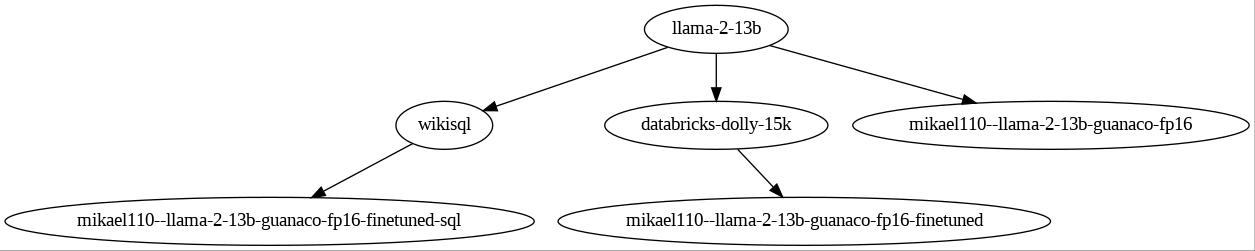

In [19]:
image_path = "test.jpg"
RenderTreeGraph(raw_node).to_picture(image_path)
Image.open(image_path)